<a href="https://colab.research.google.com/github/Ishita0807/Automobile-Sales-Service-Analytics/blob/main/Automobile_sales_and_service_analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.cluster import KMeans

sales_orig = pd.read_csv("/content/drive/MyDrive/automobile_sales_clean.csv")
service_orig = pd.read_csv("/content/drive/MyDrive/automobile_service_clean.csv")

sales_orig['Date'] = pd.to_datetime(sales_orig['Date'])
service_orig['Date'] = pd.to_datetime(service_orig['Date'])

for df in (sales_orig, service_orig):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter

sales_orig['Vehicle_Age'] = 0

print(sales_orig.head())
print(service_orig.head())


  Sale_ID       Date Region  Dealer_Name Vehicle_Model Brand    Price  \
0    S001 2023-12-01   West  Wheels Auto         Sonet   Kia   814440   
1    S002 2023-10-20   East       SpeedX         Sonet   Kia  1129495   
2    S003 2023-04-01   West       SpeedX        Seltos   Kia  1224916   
3    S004 2023-03-22  South     DriveNow        Seltos   Kia  1543512   
4    S005 2023-06-22  South   Metro Cars           EV6   Kia   975711   

   Quantity Sale_Type  Year  Month  Quarter  Vehicle_Age  
0         1      Used  2023     12        4            0  
1         1       New  2023     10        4            0  
2         1      Used  2023      4        2            0  
3         1      Used  2023      3        1            0  
4         1       New  2023      6        2            0  
  Service_ID       Date Region   Dealer_Name Vehicle_Model  \
0      SV001 2023-03-27  South   Wheels Auto         Nexon   
1      SV002 2023-06-16  South  Elite Motors        Baleno   
2      SV003 2023-09-

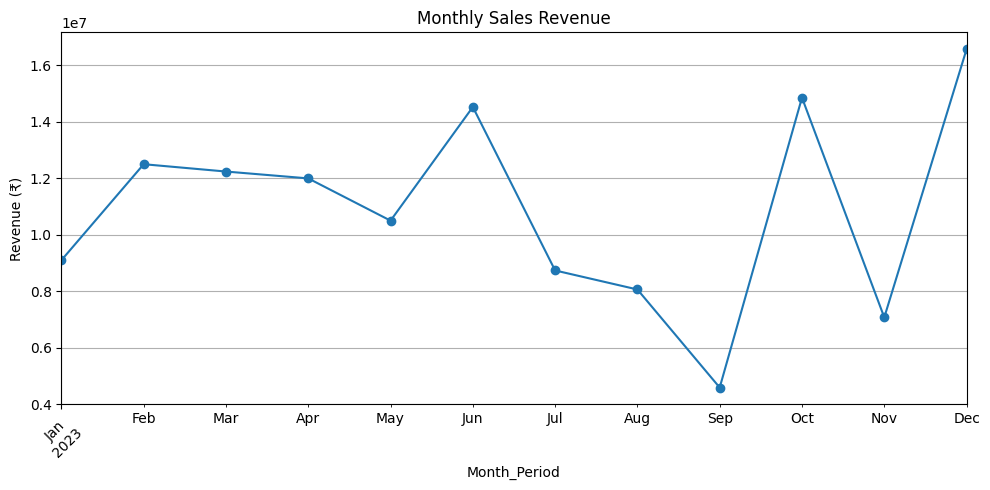

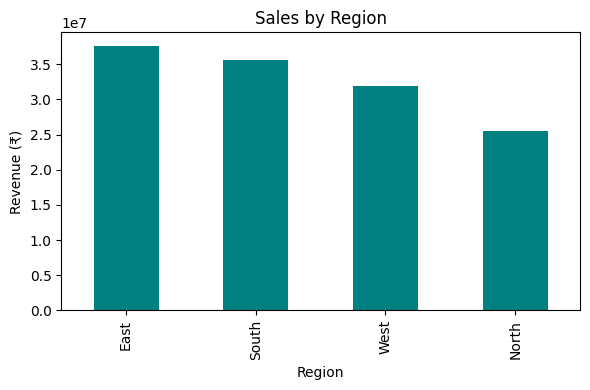

/tmp/ipython-input-296586485.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=brand_sales.index, y=brand_sales.values, palette='Set2')


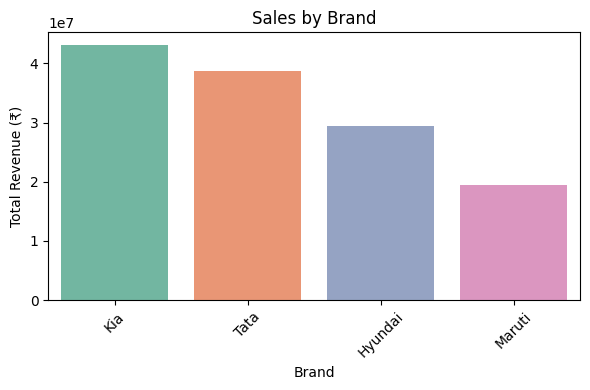

/tmp/ipython-input-296586485.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=issue_counts.values, y=issue_counts.index, palette='coolwarm')


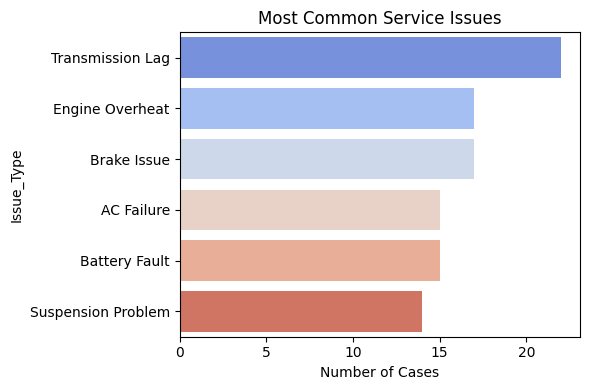

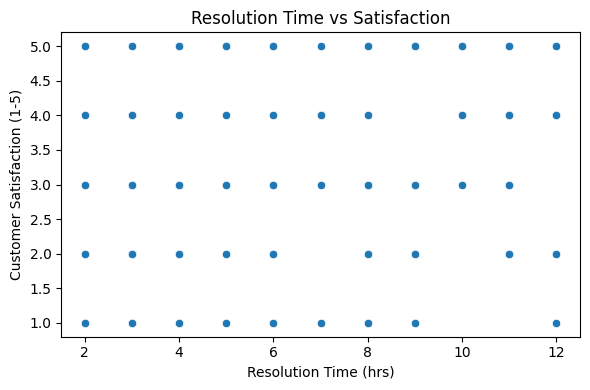

In [20]:

sales_orig['Month_Period'] = sales_orig['Date'].dt.to_period('M')
monthly_sales = sales_orig.groupby('Month_Period')['Price'].sum()

plt.figure(figsize=(10,5))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Revenue')
plt.ylabel('Revenue (₹)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Sales by Region
region_sales = sales_orig.groupby('Region')['Price'].sum().sort_values(ascending=False)
plt.figure(figsize=(6,4))
region_sales.plot(kind='bar', color='teal')
plt.title('Sales by Region')
plt.ylabel('Revenue (₹)')
plt.tight_layout()
plt.show()

# Sales by Brand
brand_sales = sales_orig.groupby('Brand')['Price'].sum().sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=brand_sales.index, y=brand_sales.values, palette='Set2')
plt.title("Sales by Brand")
plt.ylabel("Total Revenue (₹)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Most Common Service Issues
issue_counts = service_orig['Issue_Type'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=issue_counts.values, y=issue_counts.index, palette='coolwarm')
plt.title("Most Common Service Issues")
plt.xlabel("Number of Cases")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6,4))
sns.scatterplot(x='Resolution_Time_Hrs', y='Customer_Satisfaction', data=service_orig)
plt.title("Resolution Time vs Satisfaction")
plt.xlabel("Resolution Time (hrs)")
plt.ylabel("Customer Satisfaction (1-5)")
plt.tight_layout()
plt.show()


In [21]:
def generate_synthetic_sales(df, n_multiplier=20, price_noise_pct=0.08):
    df = df.copy()
    df['Segment'] = df['Brand'] + "_" + df['Sale_Type']
    segment_price_mean = df.groupby('Segment')['Price'].mean()

    synthetic_rows = []
    n_rows = len(df) * n_multiplier
    rng = np.random.default_rng(42)

    for _ in range(n_rows):
        base = df.sample(1, replace=True).iloc[0]
        seg = base['Segment']
        base_price = segment_price_mean.loc[seg]
        noise_factor = rng.normal(loc=1.0, scale=price_noise_pct)
        new_price = max(0, base_price * noise_factor)

        month_jitter = rng.integers(-1, 2)
        new_month = int(np.clip(base['Month'] + month_jitter, 1, 12))
        new_quarter = ( (new_month - 1) // 3 ) + 1
        new_day = int(rng.integers(1, 28))
        new_date = pd.Timestamp(year=base['Year'], month=new_month, day=new_day)

        synthetic_rows.append({
            'Sale_ID': base['Sale_ID'],
            'Date': new_date,
            'Region': base['Region'],
            'Dealer_Name': base['Dealer_Name'],
            'Vehicle_Model': base['Vehicle_Model'],
            'Brand': base['Brand'],
            'Price': new_price,
            'Quantity': base['Quantity'],
            'Sale_Type': base['Sale_Type'],
            'Year': base['Year'],
            'Month': new_month,
            'Quarter': new_quarter,
            'Vehicle_Age': base['Vehicle_Age']
        })

    synthetic_df = pd.DataFrame(synthetic_rows)
    return synthetic_df

sales_aug = generate_synthetic_sales(sales_orig, n_multiplier=20, price_noise_pct=0.08)

print("Original sales rows:", len(sales_orig))
print("Augmented sales rows:", len(sales_aug))

sales_aug.to_csv("/content/automobile_sales_augmented.csv", index=False)


Original sales rows: 100
Augmented sales rows: 2000


In [22]:
sales_df = sales_aug.copy()

target_col_sales = 'Price'

feature_cols_sales = [
    'Brand',
    'Region',
    'Dealer_Name',
    'Sale_Type',
    'Month',
    'Quarter',
    'Quantity',
    'Vehicle_Age'
]

X_sales = sales_df[feature_cols_sales]
y_sales = sales_df[target_col_sales]

cat_features_sales = ['Brand', 'Region', 'Dealer_Name', 'Sale_Type']
num_features_sales = ['Month', 'Quarter', 'Quantity', 'Vehicle_Age']

X_train_sales, X_test_sales, y_train_sales, y_test_sales = train_test_split(
    X_sales, y_sales, test_size=0.2, random_state=42
)

preprocessor_sales = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features_sales),
        ('num', StandardScaler(), num_features_sales)
    ]
)

ridge_model = Pipeline(steps=[
    ('preprocess', preprocessor_sales),
    ('model', Ridge(alpha=1.0, random_state=42))
])

rf_model_sales = Pipeline(steps=[
    ('preprocess', preprocessor_sales),
    ('model', RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ))
])

ridge_model.fit(X_train_sales, y_train_sales)
rf_model_sales.fit(X_train_sales, y_train_sales)

y_pred_ridge = ridge_model.predict(X_test_sales)
y_pred_rf = rf_model_sales.predict(X_test_sales)

def print_regression_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.2f}")
    print(f"{name} R²: {r2:.3f}\n")

print_regression_metrics(y_test_sales, y_pred_ridge, "Ridge (augmented)")
print_regression_metrics(y_test_sales, y_pred_rf, "RandomForest (augmented)")


Ridge (augmented) RMSE: 114388.44
Ridge (augmented) R²: 0.179

RandomForest (augmented) RMSE: 112450.73
RandomForest (augmented) R²: 0.206



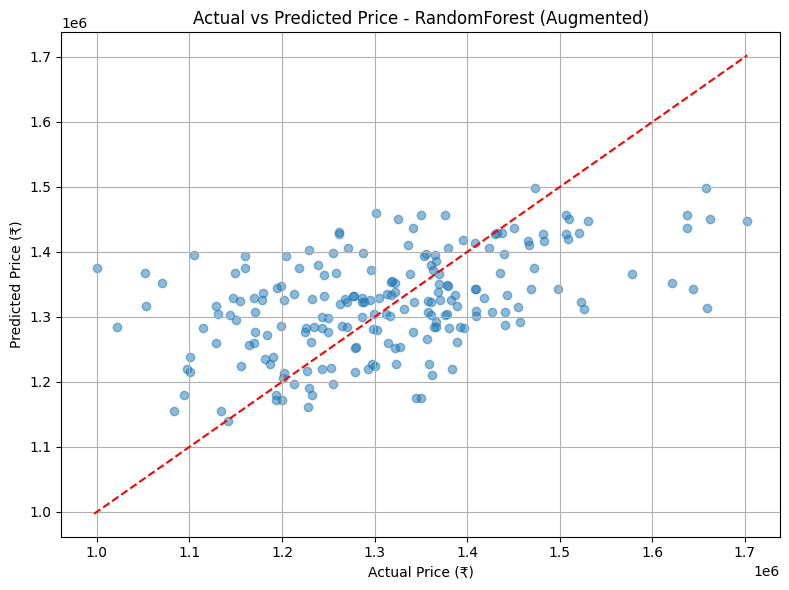

In [24]:
sample_idx = np.random.choice(len(y_test_sales), size=min(200, len(y_test_sales)), replace=False)

plt.figure(figsize=(8,6))
plt.scatter(y_test_sales.iloc[sample_idx], y_pred_rf[sample_idx], alpha=0.5)
plt.xlabel("Actual Price (₹)")
plt.ylabel("Predicted Price (₹)")
plt.title("Actual vs Predicted Price - RandomForest (Augmented)")
plt.grid(True)
vmin, vmax = y_test_sales.min(), y_test_sales.max()
plt.plot([vmin, vmax], [vmin, vmax], 'r--')
plt.tight_layout()
plt.show()


In [25]:
service_orig = service_orig.copy()
service_orig['High_Satisfaction'] = (service_orig['Customer_Satisfaction'] >= 4).astype(int)

def generate_synthetic_service(df, n_multiplier=20, time_noise_hours=1.5):
    df = df.copy()
    df['Seg'] = df['Issue_Type'] + "_" + df['High_Satisfaction'].astype(str)

    seg_res_time_mean = df.groupby('Seg')['Resolution_Time_Hrs'].mean()
    seg_satisfaction_mode = df.groupby('Seg')['Customer_Satisfaction'].agg(lambda x: x.mode().iloc[0])

    synthetic_rows = []
    n_rows = len(df) * n_multiplier
    rng = np.random.default_rng(123)

    for _ in range(n_rows):
        base = df.sample(1, replace=True).iloc[0]
        seg = base['Seg']

        base_res_time = seg_res_time_mean.loc[seg]
        res_noise = rng.normal(loc=0.0, scale=time_noise_hours)
        new_res_time = int(np.clip(round(base_res_time + res_noise), 1, 24))

        base_sat = seg_satisfaction_mode.loc[seg]
        sat_noise = rng.integers(-1, 2)
        new_sat = int(np.clip(base_sat + sat_noise, 1, 5))
        new_high = int(new_sat >= 4)

        month_jitter = rng.integers(-1, 2)
        new_month = int(np.clip(base['Month'] + month_jitter, 1, 12))
        new_quarter = ( (new_month - 1) // 3 ) + 1
        new_day = int(rng.integers(1, 28))
        new_date = pd.Timestamp(year=base['Year'], month=new_month, day=new_day)

        synthetic_rows.append({
            'Service_ID': base['Service_ID'],
            'Date': new_date,
            'Region': base['Region'],
            'Dealer_Name': base['Dealer_Name'],
            'Vehicle_Model': base['Vehicle_Model'],
            'Issue_Type': base['Issue_Type'],
            'Cost': base['Cost'],
            'Resolution_Time_Hrs': new_res_time,
            'Customer_Satisfaction': new_sat,
            'Year': base['Year'],
            'Month': new_month,
            'Quarter': new_quarter,
            'High_Satisfaction': new_high
        })

    synthetic_df = pd.DataFrame(synthetic_rows)
    return synthetic_df

service_aug = generate_synthetic_service(service_orig, n_multiplier=20, time_noise_hours=1.5)

print("Original service rows:", len(service_orig))
print("Augmented service rows:", len(service_aug))

service_aug.to_csv("/content/automobile_service_augmented.csv", index=False)


Original service rows: 100
Augmented service rows: 2000


In [26]:
service_df = service_aug.copy()

target_col_service = 'High_Satisfaction'

feature_cols_service = [
    'Dealer_Name',
    'Issue_Type',
    'Region',
    'Vehicle_Model',
    'Resolution_Time_Hrs',
    'Month',
    'Quarter'
]

X_service = service_df[feature_cols_service]
y_service = service_df[target_col_service]

cat_features_service = ['Dealer_Name', 'Issue_Type', 'Region', 'Vehicle_Model', 'Month', 'Quarter']
num_features_service = ['Resolution_Time_Hrs']

X_train_serv, X_test_serv, y_train_serv, y_test_serv = train_test_split(
    X_service, y_service, test_size=0.2, random_state=42, stratify=y_service
)

preprocessor_service = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features_service),
        ('num', StandardScaler(), num_features_service)
    ]
)

log_reg_model = Pipeline(steps=[
    ('preprocess', preprocessor_service),
    ('model', LogisticRegression(max_iter=1000))
])

rf_model_service = Pipeline(steps=[
    ('preprocess', preprocessor_service),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ))
])

log_reg_model.fit(X_train_serv, y_train_serv)
rf_model_service.fit(X_train_serv, y_train_serv)

y_pred_log = log_reg_model.predict(X_test_serv)
y_pred_rf_serv = rf_model_service.predict(X_test_serv)

def print_clf_metrics(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {acc:.3f}")
    print(f"{name} Classification Report:")
    print(classification_report(y_true, y_pred))

print_clf_metrics(y_test_serv, y_pred_log, "Logistic Regression (augmented)")
print_clf_metrics(y_test_serv, y_pred_rf_serv, "Random Forest (augmented)")


Logistic Regression (augmented) Accuracy: 0.740
Logistic Regression (augmented) Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       231
           1       0.74      0.59      0.66       169

    accuracy                           0.74       400
   macro avg       0.74      0.72      0.72       400
weighted avg       0.74      0.74      0.73       400

Random Forest (augmented) Accuracy: 0.838
Random Forest (augmented) Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       231
           1       0.82      0.79      0.80       169

    accuracy                           0.84       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.84      0.84      0.84       400



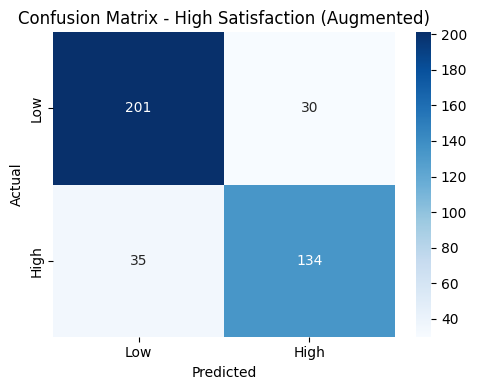

In [27]:
cm = confusion_matrix(y_test_serv, y_pred_rf_serv)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - High Satisfaction (Augmented)')
plt.tight_layout()
plt.show()


In [28]:
dealer_sales = sales_orig.groupby('Dealer_Name').agg(
    Total_Sales_Value=('Price', 'sum'),
    Num_Sales=('Sale_ID', 'count')
).reset_index()

dealer_service = service_orig.groupby('Dealer_Name').agg(
    Avg_Satisfaction=('Customer_Satisfaction', 'mean'),
    Avg_Resolution_Time=('Resolution_Time_Hrs', 'mean'),
    Num_Service_Cases=('Service_ID', 'count')
).reset_index()

dealer_merged = pd.merge(dealer_sales, dealer_service, on='Dealer_Name', how='outer').fillna(0)

cluster_features = [
    'Total_Sales_Value',
    'Num_Sales',
    'Avg_Satisfaction',
    'Avg_Resolution_Time',
    'Num_Service_Cases'
]

X_cluster = dealer_merged[cluster_features]

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
dealer_merged['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

print(dealer_merged)


    Dealer_Name  Total_Sales_Value  Num_Sales  Avg_Satisfaction  \
0      DriveNow           24041523         18          3.000000   
1  Elite Motors           34633212         27          3.705882   
2    Metro Cars           23145406         17          2.863636   
3        SpeedX           23914830         19          3.333333   
4   Wheels Auto           24990076         19          3.238095   

   Avg_Resolution_Time  Num_Service_Cases  Cluster  
0             7.136364                 22        1  
1             6.764706                 17        0  
2             6.590909                 22        1  
3             7.888889                 18        2  
4             6.523810                 21        1  


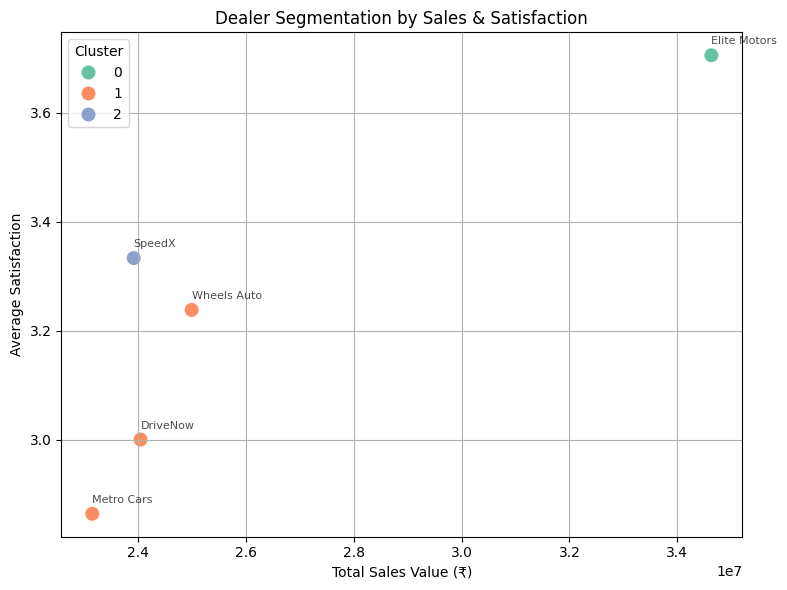

In [29]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=dealer_merged,
    x='Total_Sales_Value',
    y='Avg_Satisfaction',
    hue='Cluster',
    palette='Set2',
    s=120
)

for _, row in dealer_merged.iterrows():
    plt.text(
        row['Total_Sales_Value'],
        row['Avg_Satisfaction'] + 0.02,
        row['Dealer_Name'],
        fontsize=8,
        alpha=0.7
    )

plt.xlabel('Total Sales Value (₹)')
plt.ylabel('Average Satisfaction')
plt.title('Dealer Segmentation by Sales & Satisfaction')
plt.grid(True)
plt.tight_layout()
plt.show()
